In [197]:
%run ./PM_functions_Units.ipynb

# Example cases
We're not completely sure about the actual units yet...

## 1) Testbody limit w/ Johans initial conditions

In [2]:
m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

N = 3 # Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM')
# print(positions[2])

#~1 min at res=1e5

In [3]:
m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

V_eff_N = TotalEnergy(s, DL = True, mode = 'N')[1]
V_eff_EIH= TotalEnergy(s, DL = True, mode = 'EIH')[1]
V_eff_1PM = TotalEnergy(s, DL = True, mode = '1PM')[1]
V_eff_2PM = TotalEnergy(s, DL = True, mode = '2PM')[1]

print(f'V_eff_N = {V_eff_N:.2e}')
print(f'V_eff_EIH = {V_eff_EIH:.2e}')
print(f'V_eff_1PM = {V_eff_1PM:.2e}')
print(f'V_eff_2PM = {V_eff_2PM:.2e}')

V_eff_N = -1.00e+00
V_eff_EIH = -1.00e+00
V_eff_1PM = -5.01e-08
V_eff_2PM = -5.01e-08


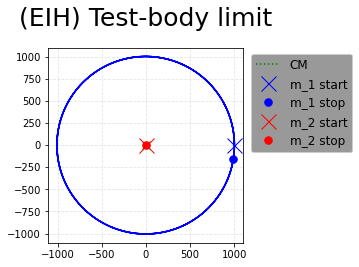

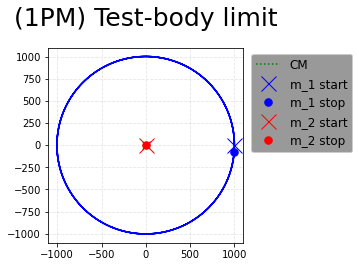

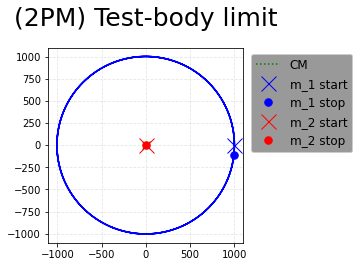

In [4]:
lim = 0
# lims = (-lim, lim)
orbPlotter(positions_EIH, DL = True, CM = True, xlim=lim, ylim=lim, filename='(EIH) Test-body limit', figsize=(5,5), save=False)
orbPlotter(positions_1PM, DL = True, CM = True, xlim=lim, ylim=lim, filename='(1PM) Test-body limit', figsize=(5,5), save=False)
orbPlotter(positions_2PM, DL = True, CM = True, xlim=lim, ylim=lim, filename='(2PM) Test-body limit', figsize=(5,5), save=False)

## 2) Testbody limit w/ Johans initial conditions with eccentricity

In [204]:
m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

# R_S = 2*(b1_mass + b2_mass)*G/c**2
R_S = 2*(b1_mass + b2_mass)

mass_bin = b1_mass + b2_mass
SMA_bin = 1000


α = 0.5
v_redmass = α*np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

N =  α*6# Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_N = run_model(s, t_max, dt, DL = True, mode = 'N')
positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM')
# print(positions[2])

#~1 min at res=1e5 STABILIZED
#~10 min at res=1e6

In [205]:
m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

# R_S = 2*(b1_mass + b2_mass)*G/c**2
R_S = 2*(b1_mass + b2_mass)

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
α = 0.5
v_redmass = α*np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

V_eff_N = TotalEnergy(s, DL = True, mode = 'N')[1]
V_eff_EIH= TotalEnergy(s, DL = True, mode = 'EIH')[1]
V_eff_1PM = TotalEnergy(s, DL = True, mode = '1PM')[1]
V_eff_2PM = TotalEnergy(s, DL = True, mode = '2PM')[1]

print(f'V_eff_N = {V_eff_N:.2e}')
print(f'V_eff_EIH = {V_eff_EIH:.2e}')
print(f'V_eff_1PM = {V_eff_1PM:.2e}')
print(f'V_eff_2PM = {V_eff_2PM:.2e}')

V_eff_N = -1.00e+00
V_eff_EIH = -1.00e+00
V_eff_1PM = -8.75e-08
V_eff_2PM = -8.75e-08


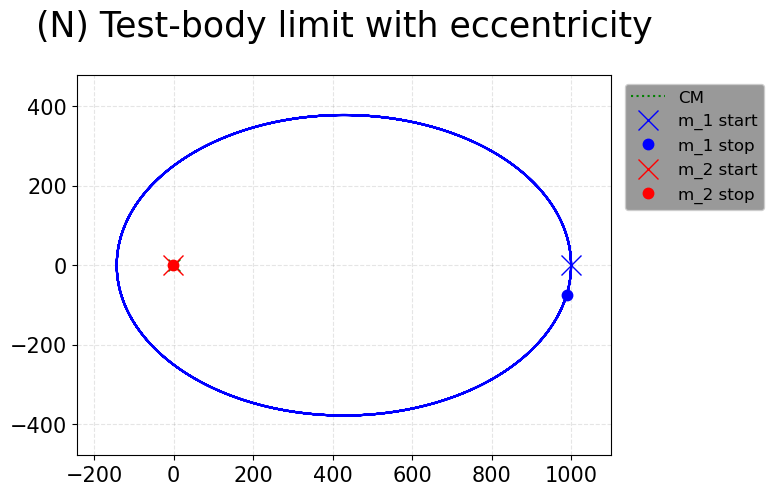

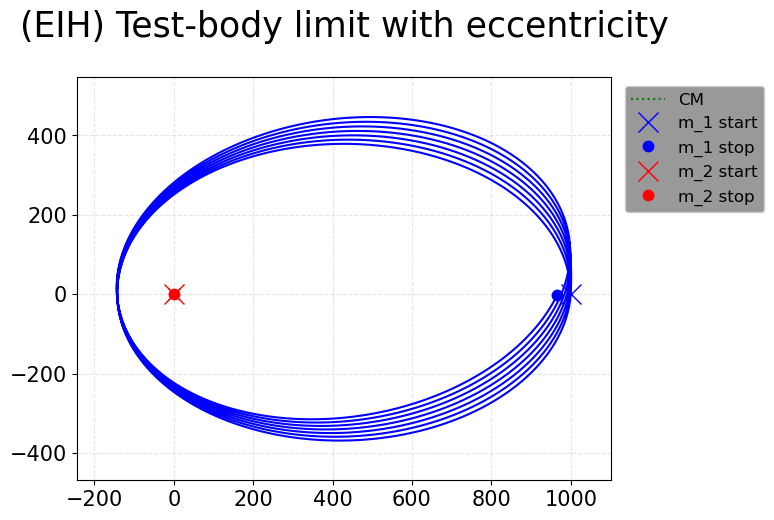

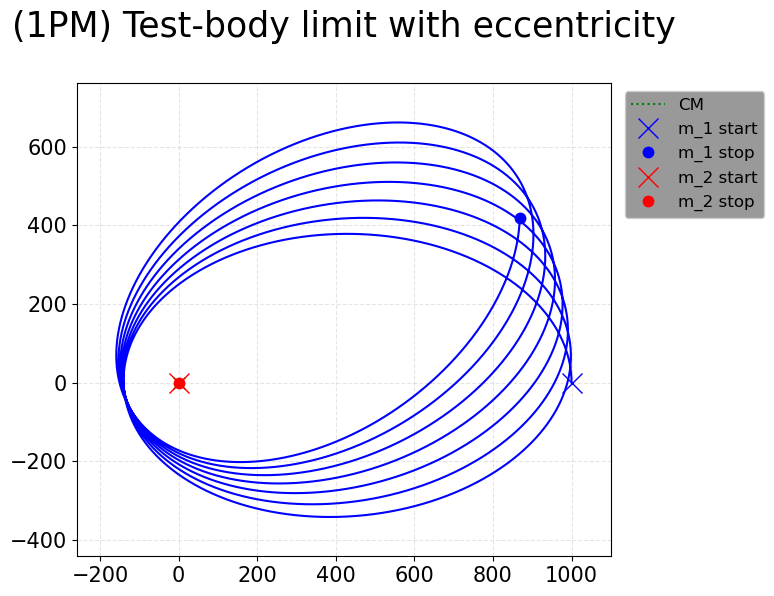

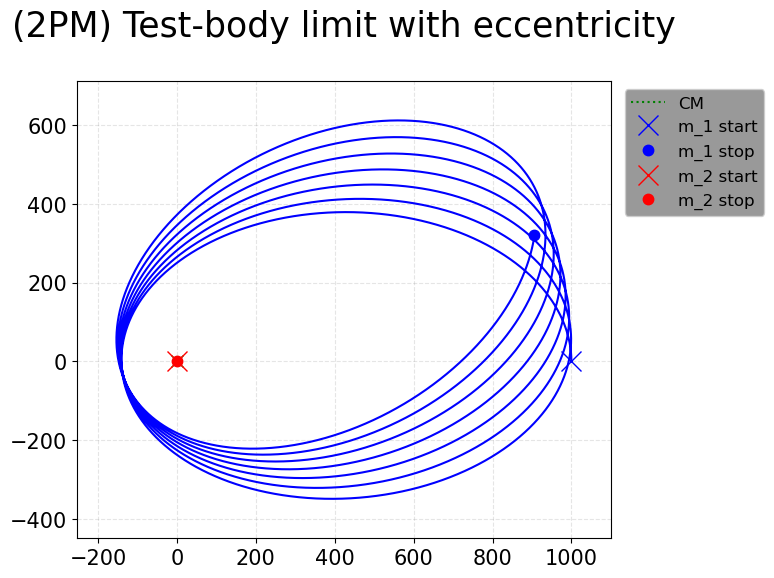

In [206]:
lim = 0
# lims = (-lim, lim)
orbPlotter(positions_N, DL = True, CM = True, xlim=lim, ylim=lim, filename='(N) Test-body limit with eccentricity',save=False)
orbPlotter(positions_EIH, DL = True, CM = True, xlim=lim, ylim=lim, filename='(EIH) Test-body limit with eccentricity',save=False)
orbPlotter(positions_1PM, DL = True, CM = True, xlim=lim, ylim=lim, filename='(1PM) Test-body limit with eccentricity',save=False)
orbPlotter(positions_2PM, DL = True, CM = True, xlim=lim, ylim=lim, filename='(2PM) Test-body limit with eccentricity',save=False)

In [207]:
φ_N_an = perihelionShift_analytical(s, DL=True, mode='N')
φ_EIH_an = perihelionShift_analytical(s, DL=True, mode='EIH')
φ_1PM_an = perihelionShift_analytical(s, DL=True, mode='1PM')
φ_2PM_an = perihelionShift_analytical(s, DL=True, mode='2PM')

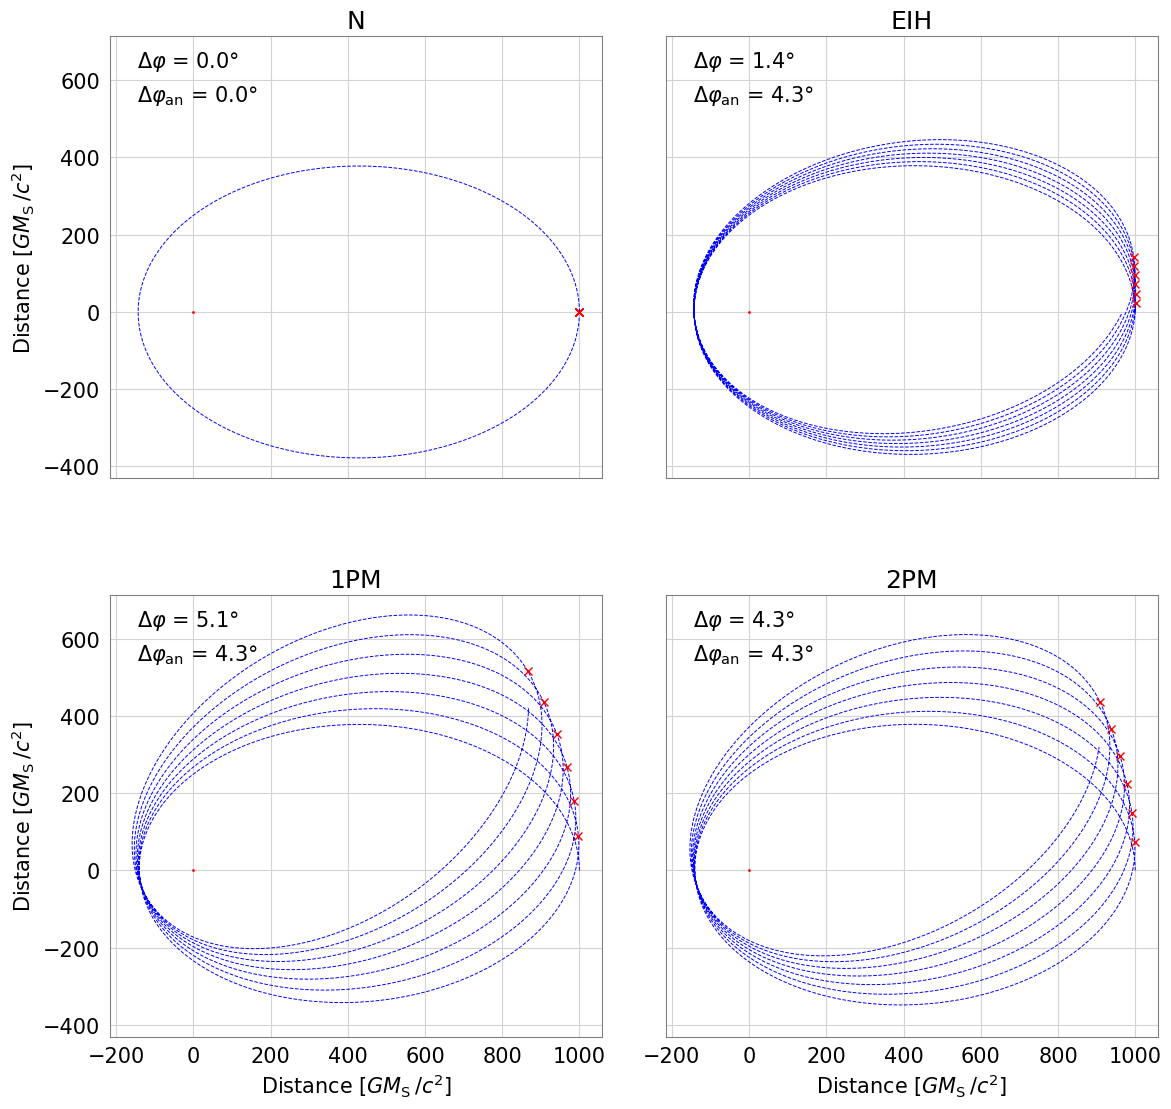

In [213]:
rs_N, peakPositions_N, peakAngles_N, perihelionShift_N = perihelionShift(positions_N[0]) 
rs_EIH, peakPositions_EIH, peakAngles_EIH, perihelionShift_EIH = perihelionShift(positions_EIH[0]) 
rs_1PM, peakPositions_1PM, peakAngles_1PM, perihelionShift_1PM = perihelionShift(positions_1PM[0])    
rs_2PM, peakPositions_2PM, peakAngles_2PM, perihelionShift_2PM = perihelionShift(positions_2PM[0])


plt.style.use('default')
plt.rcParams.update({'font.size':15})

fig, axs = plt.subplots(2,2, figsize=(12,12), sharex = True, sharey = True)

axs[0,0].set_aspect('equal')
axs[0,0].plot(positions_N[0,0][0:14300], positions_N[0,1][0:14300], 'b--', lw=0.7)
axs[0,0].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_N*180/np.pi:.1f}°')
axs[0,0].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_N_an:.1f}°')
axs[0,0].plot(0,0,'r.', markersize=2)
axs[0,0].set_title('N')
# axs[0,0].set_ylim(-700, 700)
axs[0,0].set_ylabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[0,0].legend(loc=(-0.08, 0.82), frameon=False)

axs[0,1].set_aspect('equal')
axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_EIH*180/np.pi:.1f}°')
axs[0,1].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_EIH_an:.1f}°')
axs[0,1].plot(0,0,'r.', markersize=2)
axs[0,1].set_title('EIH')
axs[0,1].legend(loc=(-0.08, 0.82), frameon=False)

axs[1,0].set_aspect('equal')
axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_1PM*180/np.pi:.1f}°')
axs[1,0].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_1PM_an:.1f}°')
axs[1,0].plot(0,0,'r.', markersize=2)
axs[1,0].set_title('1PM')
axs[1,0].set_ylabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,0].set_xlabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,0].legend(loc=(-0.08, 0.82), frameon=False)

axs[1,1].set_aspect('equal')
axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_2PM*180/np.pi:.1f}°')
axs[1,1].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_2PM_an:.1f}°')
axs[1,1].plot(0,0,'r.', markersize=2)
axs[1,1].set_title('2PM')
axs[1,1].set_xlabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,1].legend(loc=(-0.08, 0.82), frameon=False)

for i in range(len(peakPositions_EIH)):
    axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
    axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
    axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
    axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
# print(f'The perihelionShift in the three cases are (N:) {perihelionShift_N*180/np.pi:.3f}°, (EIH:) {perihelionShift_EIH*180/np.pi:.3f}°, (1PM): {perihelionShift_1PM*180/np.pi:.3f}°, (2PM): {perihelionShift_2PM*180/np.pi:.3f}°')

axs = axs.flatten()

for ax in axs:
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.grid(color='lightgray')

fig.tight_layout()
# fig.savefig('test body perihelion shift.jpg', dpi=300)


In [9]:
R_S = 2*(b1_mass + b2_mass)*M_sun*G/c**2
print(f'R_S = {R_S:.2e}')

R_S = 2.95e+03 m


In [10]:
G = const.G.value
c = const.c.value

m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

R_S = 2*(b1_mass + b2_mass)*M_sun*G/c**2

δxN = np.abs(max(positions_N[0,0][0:14300]) - min(positions_N[0,0][0:14300]))
δyN = np.abs(max(positions_N[0,1][0:14300]) - min(positions_N[0,1][0:14300]))

a_N = max(δxN/2, δyN/2)*M_sun*G/c**2
b_N = min(δxN/2, δyN/2)*M_sun*G/c**2

e = np.sqrt(1 - b_N**2/a_N**2)

# Calculating the analytically predicted value of the precession angle (in radians), and how many times it divides 2π radians.
Δφr = 6*G*np.pi*(m_1 + m_2)*M_sun/((1 - e**2)*a_N*c**2)
Δφa = Δφr*180/np.pi #Convert to angles
print(f'Δφ (in radians) = {Δφr:.3f}, Δφ (in angles) = {Δφa:.3f}')

Δφ (in radians) = 0.075, Δφ (in angles) = 4.321


571.371510967116 377.92756218414024


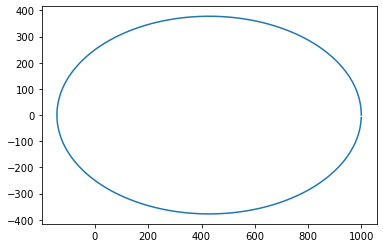

In [11]:
plt.plot(positions_N[0,0][0:14300], positions_N[0,1][0:14300])
print(δxN/2, δyN/2)

## 3) Similar mass binary system

In [12]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

N = 2 # Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM')

#~1 min at res=1e5

In [13]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

V_eff_N = TotalEnergy(s, DL = True, mode = 'N')[1]
V_eff_EIH = TotalEnergy(s, DL = True, mode = 'EIH')[1]
V_eff_1PM = TotalEnergy(s, DL = True, mode = '1PM')[1]
V_eff_2PM = TotalEnergy(s, DL = True, mode = '2PM')[1]

print(f'V_eff_N = {V_eff_N:.2e}')
print(f'V_eff_EIH = {V_eff_EIH:.2e}')
print(f'V_eff_1PM = {V_eff_1PM:.2e}')
print(f'V_eff_2PM = {V_eff_2PM:.2e}')

V_eff_N = -4.00e+00
V_eff_EIH = -4.00e+00
V_eff_1PM = -2.03e-03
V_eff_2PM = -2.02e-03


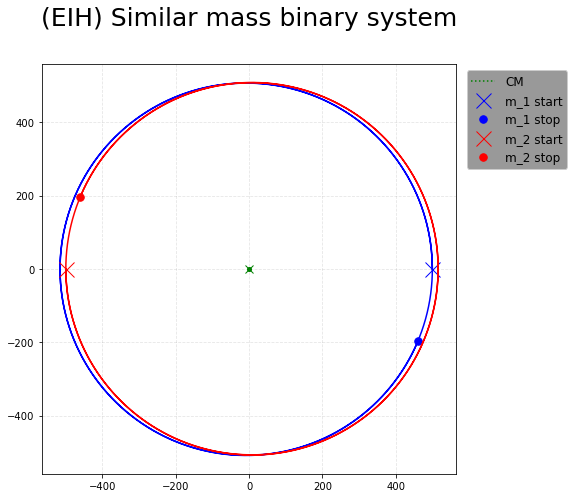

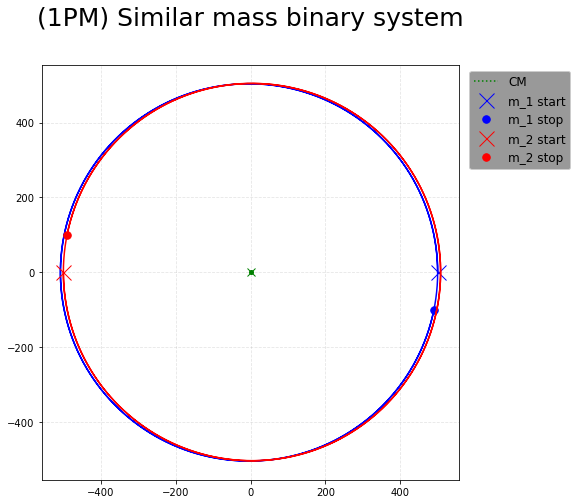

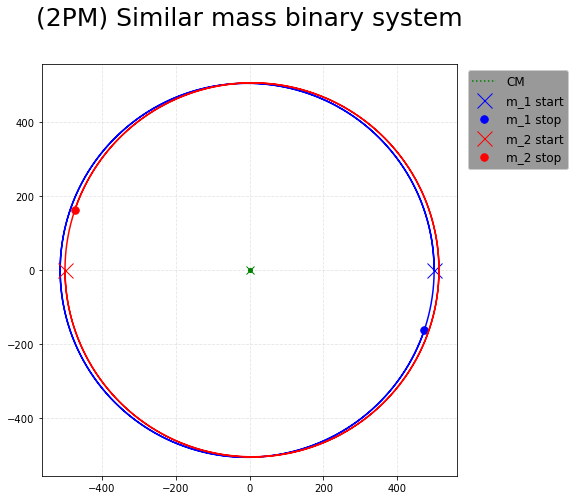

In [14]:
# lim = 500
# orbPlotter(positions, DL = True, xlim=(-lim,lim), ylim=(-lim,lim))

orbPlotter(positions_EIH, DL = True, CM = True, filename='(EIH) Similar mass binary system', save=False)
orbPlotter(positions_1PM, DL = True, CM = True, filename='(1PM) Similar mass binary system', save=False)
orbPlotter(positions_2PM, DL = True, CM = True, filename='(2PM) Similar mass binary system', save=False)

## 4) Similar mass binary system w/ eccentricty (hopefully)

In [163]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000

α = 0.5
v_redmass = α*np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

N =  α*5# Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_N = run_model(s, t_max, dt, DL = True, mode = 'N')
positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM')

#~1 min at res=1e5

In [164]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000

α = 0.5
v_redmass = α*np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

V_eff_N = TotalEnergy(s, DL = True, mode = 'N')[1]
V_eff_EIH= TotalEnergy(s, DL = True, mode = 'EIH')[1]
V_eff_1PM = TotalEnergy(s, DL = True, mode = '1PM')[1]
V_eff_2PM = TotalEnergy(s, DL = True, mode = '2PM')[1]

print(f'V_eff_N = {V_eff_N:.2e}')
print(f'V_eff_EIH = {V_eff_EIH:.2e}')
print(f'V_eff_1PM = {V_eff_1PM:.2e}')
print(f'V_eff_2PM = {V_eff_2PM:.2e}')

V_eff_N = -4.00e+00
V_eff_EIH = -4.00e+00
V_eff_1PM = -3.51e-03
V_eff_2PM = -3.50e-03


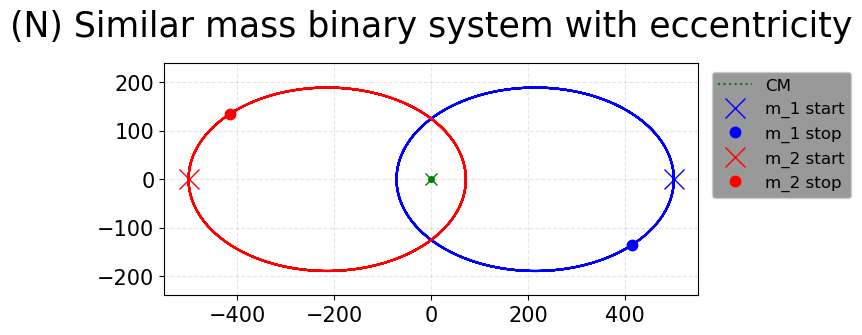

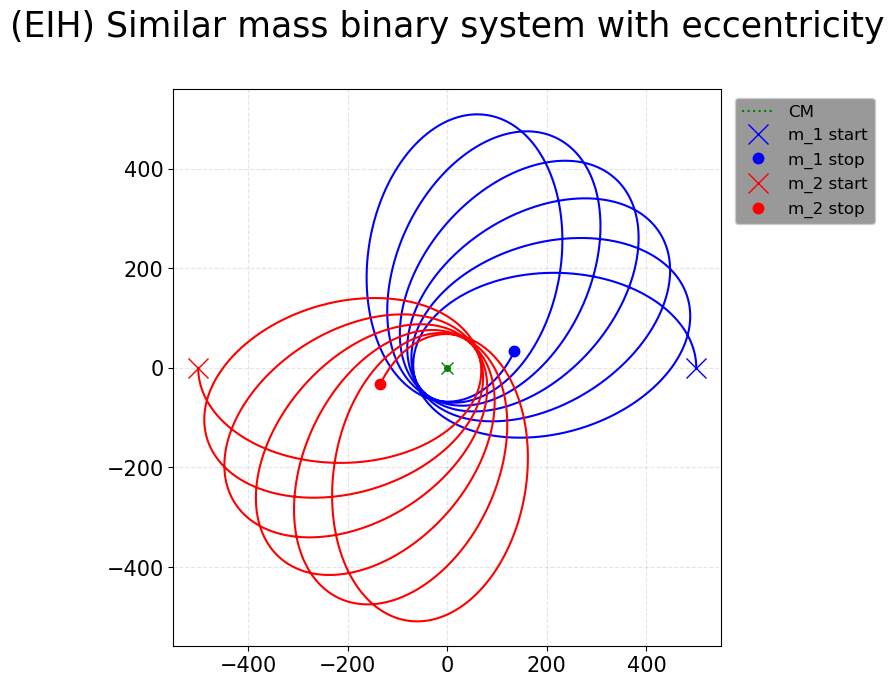

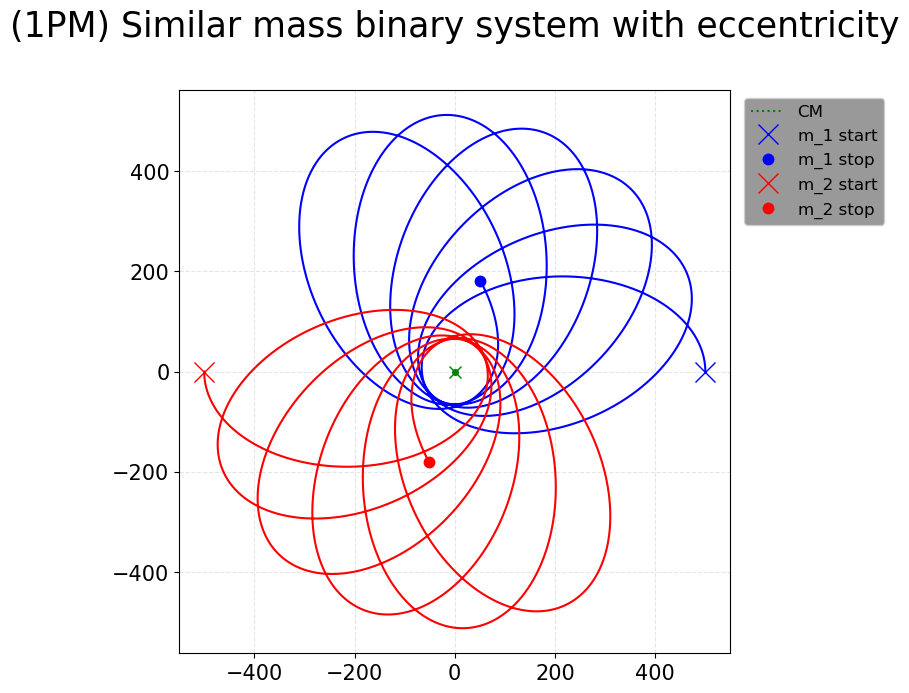

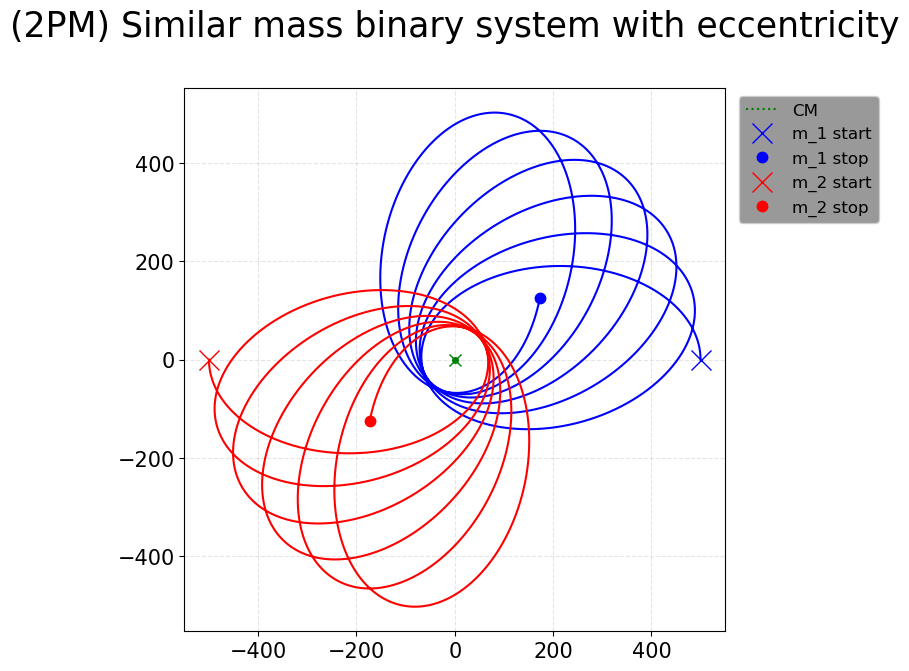

In [165]:
# lim = 500
# orbPlotter(positions, DL = True, xlim=(-lim,lim), ylim=(-lim,lim))

orbPlotter(positions_N, DL = True, CM = False, filename='(N) Similar mass binary system with eccentricity', save=False)
orbPlotter(positions_EIH, DL = True, CM = False, filename='(EIH) Similar mass binary system with eccentricity', save=False)
orbPlotter(positions_1PM, DL = True, CM = False, filename='(1PM) Similar mass binary system with eccentricity', save=False)
orbPlotter(positions_2PM, DL = True, CM = False, filename='(2PM) Similar mass binary system with eccentricity', save=False)

The angle between two vectors is $θ = \arccos \left(\frac{\mathbf a \cdot \mathbf b}{a b}\right)  $

In [178]:
φ_N_an = perihelionShift_analytical(s, DL=True, mode='N')
φ_EIH_an = perihelionShift_analytical(s, DL=True, mode='EIH')
φ_1PM_an = perihelionShift_analytical(s, DL=True, mode='1PM')
φ_2PM_an = perihelionShift_analytical(s, DL=True, mode='2PM')

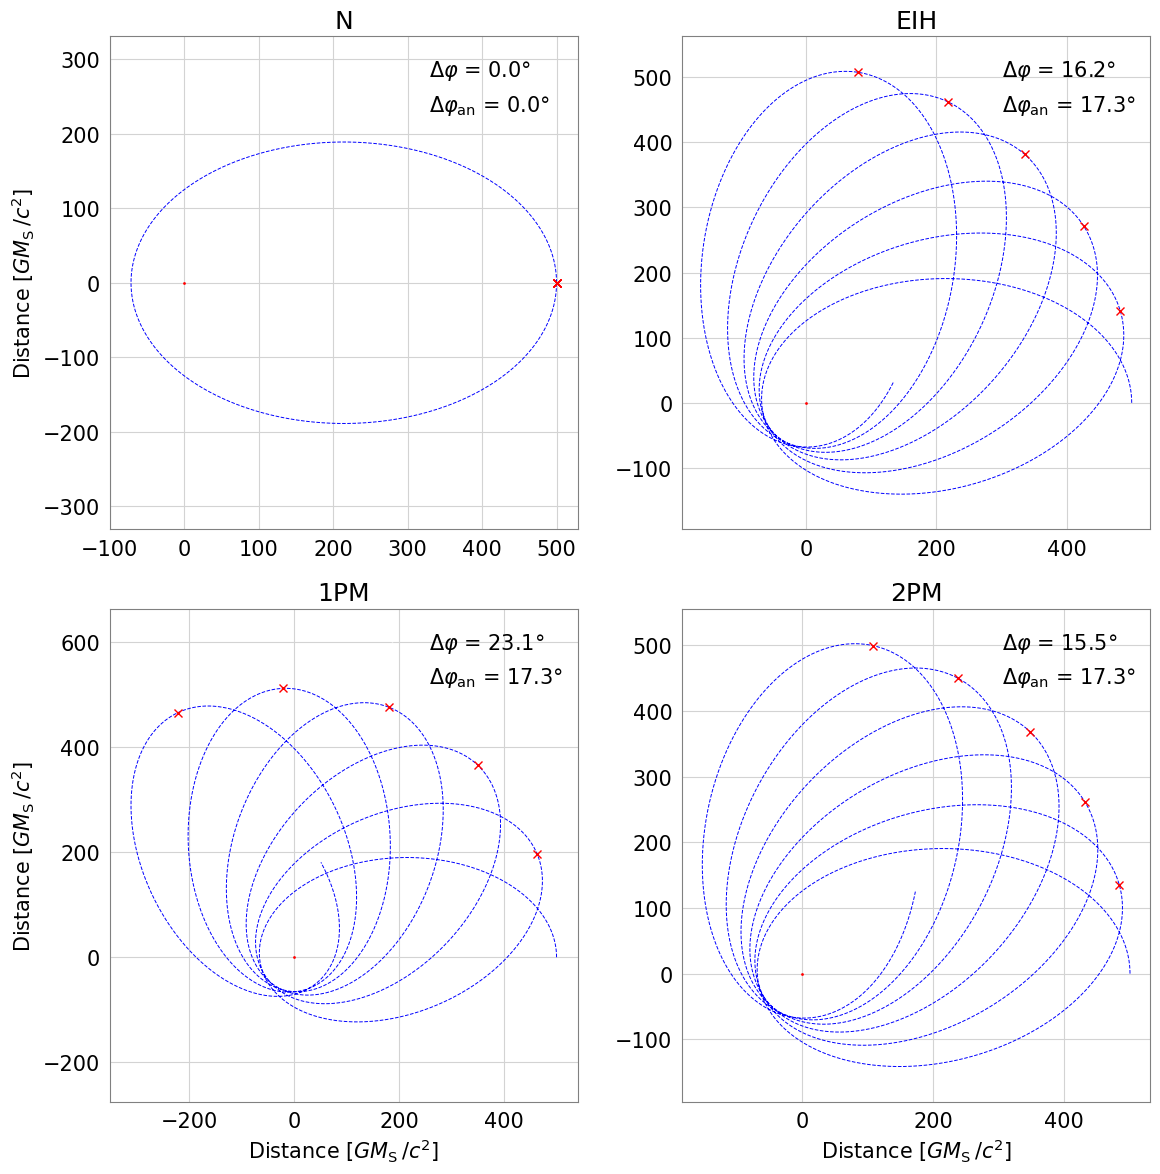

In [180]:
rs_N, peakPositions_N, peakAngles_N, perihelionShift_N = perihelionShift(positions_N[0]) 
rs_EIH, peakPositions_EIH, peakAngles_EIH, perihelionShift_EIH = perihelionShift(positions_EIH[0]) 
rs_1PM, peakPositions_1PM, peakAngles_1PM, perihelionShift_1PM = perihelionShift(positions_1PM[0])    
rs_2PM, peakPositions_2PM, peakAngles_2PM, perihelionShift_2PM = perihelionShift(positions_2PM[0])


plt.style.use('default')
plt.rcParams.update({'font.size':15})

fig, axs = plt.subplots(2,2, figsize=(12,12))

axs[0,0].set_aspect('equal', adjustable='datalim')
axs[0,0].plot(positions_N[0,0][0:17300], positions_N[0,1][0:17300], 'b--', lw=0.7)
axs[0,0].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_N*180/np.pi:.1f}°')
axs[0,0].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_N_an:.1f}°')
axs[0,0].plot(0,0,'r.', markersize=2)
axs[0,0].set_title('N')
axs[0,0].set_ylabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[0,0].legend(loc=(0.54, 0.82), frameon=False)

axs[0,1].set_aspect('equal', adjustable='datalim')
axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_EIH*180/np.pi:.1f}°')
axs[0,1].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_EIH_an:.1f}°')
axs[0,1].plot(0,0,'r.', markersize=2)
axs[0,1].set_title('EIH')
axs[0,1].legend(loc=(0.54, 0.82), frameon=False)

axs[1,0].set_aspect('equal', adjustable='datalim')
axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_1PM*180/np.pi:.1f}°')
axs[1,0].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_1PM_an:.1f}°')
axs[1,0].plot(0,0,'r.', markersize=2)
axs[1,0].set_title('1PM')
axs[1,0].set_ylabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,0].set_xlabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,0].legend(loc=(0.54, 0.82), frameon=False)

axs[1,1].set_aspect('equal', adjustable='datalim')
axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].plot(0,0,'w.', markersize=1, label=f'$Δφ$ = {perihelionShift_2PM*180/np.pi:.1f}°')
axs[1,1].plot(0,0,'w.', markersize=1, label='$Δφ_\mathrm{an}$ = '+f'{φ_2PM_an:.1f}°')
axs[1,1].plot(0,0,'r.', markersize=2)
axs[1,1].set_title('2PM')
axs[1,1].set_xlabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,1].legend(loc=(0.54, 0.82), frameon=False)

for i in range(len(peakPositions_EIH)):
    axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
    axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
    axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
    axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
# print(f'The perihelionShift in the three cases are (N:) {perihelionShift_N*180/np.pi:.3f}°, (EIH:) {perihelionShift_EIH*180/np.pi:.3f}°, (1PM): {perihelionShift_1PM*180/np.pi:.3f}°, (2PM): {perihelionShift_2PM*180/np.pi:.3f}°')

axs = axs.flatten()

for ax in axs:
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.grid(color='lightgray')

fig.tight_layout()
# fig.savefig('similar mass perihelion shift.jpg', dpi=300)

# SCATTERING

In [187]:
m_1 = 1e-6
m_2 = 5

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 500.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.9,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2


t_max = 2e4
res = 3e4
dt = t_max/res

# positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH', scattering=True)
# positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM', scattering=True)
# positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM', scattering=True)

positions_N = run_model(s, t_max, dt, DL = True, mode = 'N', scattering=False)
positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH', scattering=False)
positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM', scattering=False)
positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM', scattering=False)


# For the graph in the paper
# m_1 = 1e-6
# m_2 = 5

# R_S = 2*(m_1 + m_2)

# x_1 = np.array([-3e3, 400.])
# x_2 = np.array([0.,    0.])
# v_1 = np.array([0.4,   0.])
# v_2 = np.array([0.,    0.])

In [188]:
m_1 = 1e-6
m_2 = 5

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 500.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.9,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2

V_eff_N = TotalEnergy(s, DL = True, mode = 'N')[1]
V_eff_EIH= TotalEnergy(s, DL = True, mode = 'EIH')[1]
V_eff_1PM = TotalEnergy(s, DL = True, mode = '1PM')[1]
V_eff_2PM = TotalEnergy(s, DL = True, mode = '2PM')[1]

print(f'V_eff_N = {V_eff_N:.2e}')
print(f'V_eff_EIH = {V_eff_EIH:.2e}')
print(f'V_eff_1PM = {V_eff_1PM:.2e}')
print(f'V_eff_2PM = {V_eff_2PM:.2e}')

V_eff_N = -5.00e+00
V_eff_EIH = -5.00e+00
V_eff_1PM = 1.29e-06
V_eff_2PM = 1.29e-06


In [198]:
θ_N_an = scatteringAngle_analytical(s, DL=True, mode = 'N')
θ_EIH_an = scatteringAngle_analytical(s, DL=True, mode = 'EIH')
θ_1PM_an = scatteringAngle_analytical(s, DL=True, mode = '1PM')
θ_2PM_an = scatteringAngle_analytical(s, DL=True, mode = '2PM')

θ_N_an, θ_1PM_an, θ_2PM_an

(array([1.41463902e+00, 1.03237060e-03]),
 array([2.56062723e+00, 1.03237060e-03]),
 array([2.64079394e+00, 1.03237060e-03]))

θ_N = 1.41°
θ_EIH = 8.32°
θ_1PM = 2.64°
θ_2PM = 2.59°


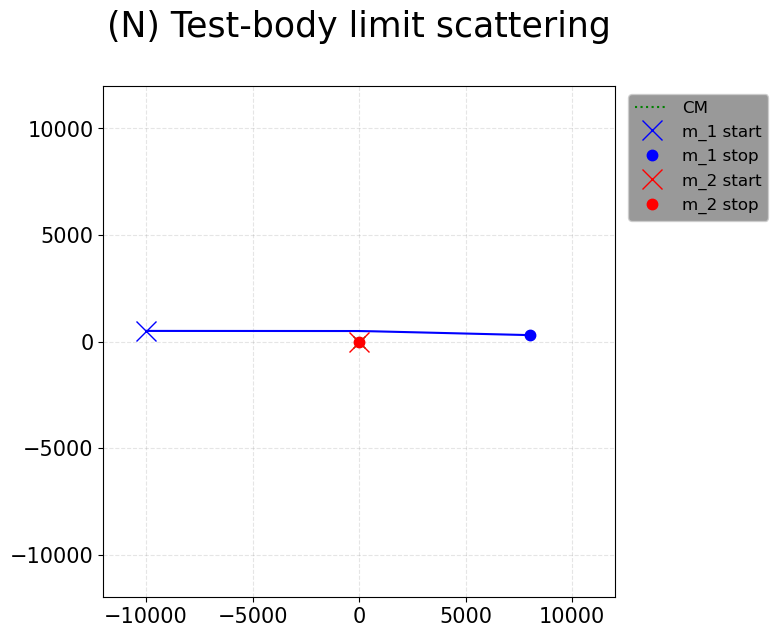

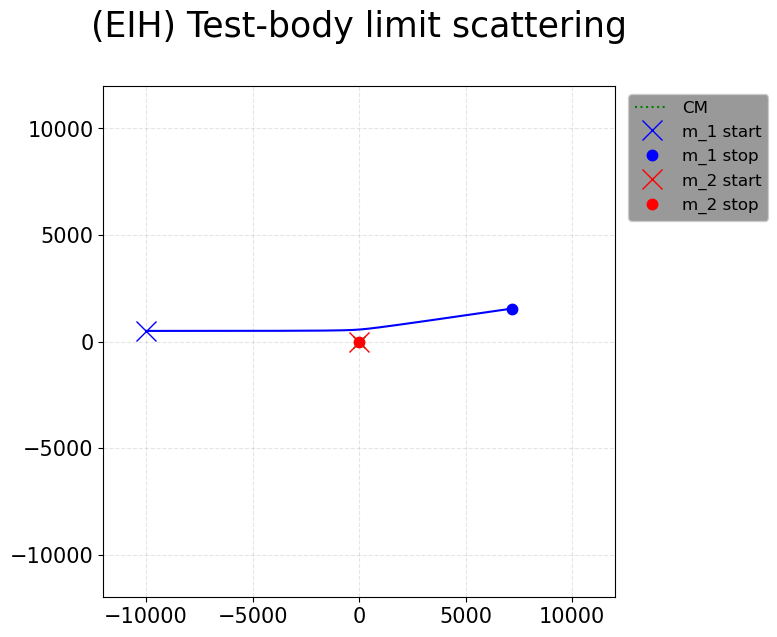

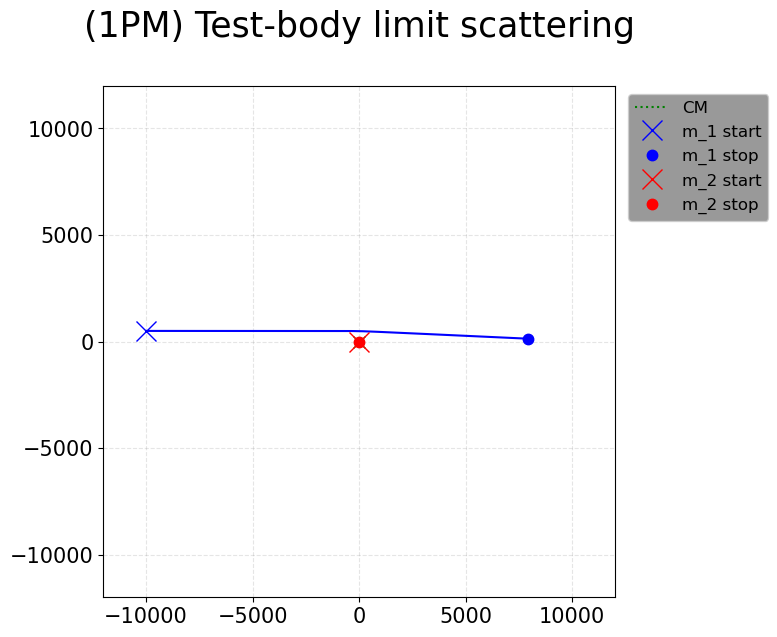

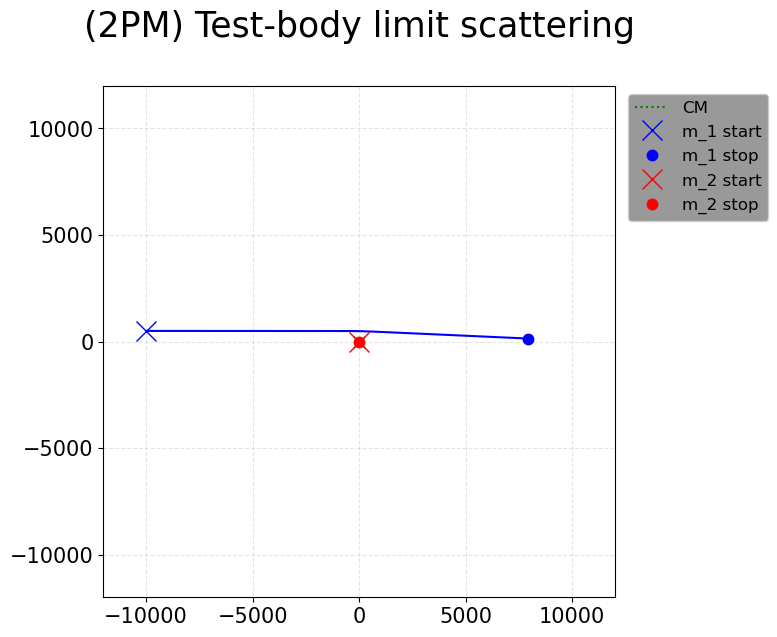

In [194]:
lim = 1.2e4
# lims = 0
lims = (-lim,lim)
orbPlotter(positions_N, DL = True, CM = True, filename='(N) Test-body limit scattering', xlim=lims, ylim=lims, save=False)
orbPlotter(positions_EIH, DL = True, CM = True, filename='(EIH) Test-body limit scattering', xlim=lims, ylim=lims, save=False)
orbPlotter(positions_1PM, DL = True, CM = True, filename='(1PM) Test-body limit scattering', xlim=lims, ylim=lims, save=False)
orbPlotter(positions_2PM, DL = True, CM = True, filename='(2PM) Test-body limit scattering', xlim=lims, ylim=lims, save=False)

print(f'θ_N = {scatteringAngle(positions_N):.2f}°')
print(f'θ_EIH = {scatteringAngle(positions_EIH):.2f}°')
print(f'θ_1PM = {scatteringAngle(positions_1PM):.2f}°')
print(f'θ_2PM = {scatteringAngle(positions_2PM):.2f}°')

In [195]:
positions_2PM[0,:,0], positions_2PM[0,:,-1]

(array([-10000.,    500.]), array([7944.11843577,  140.92962203]))

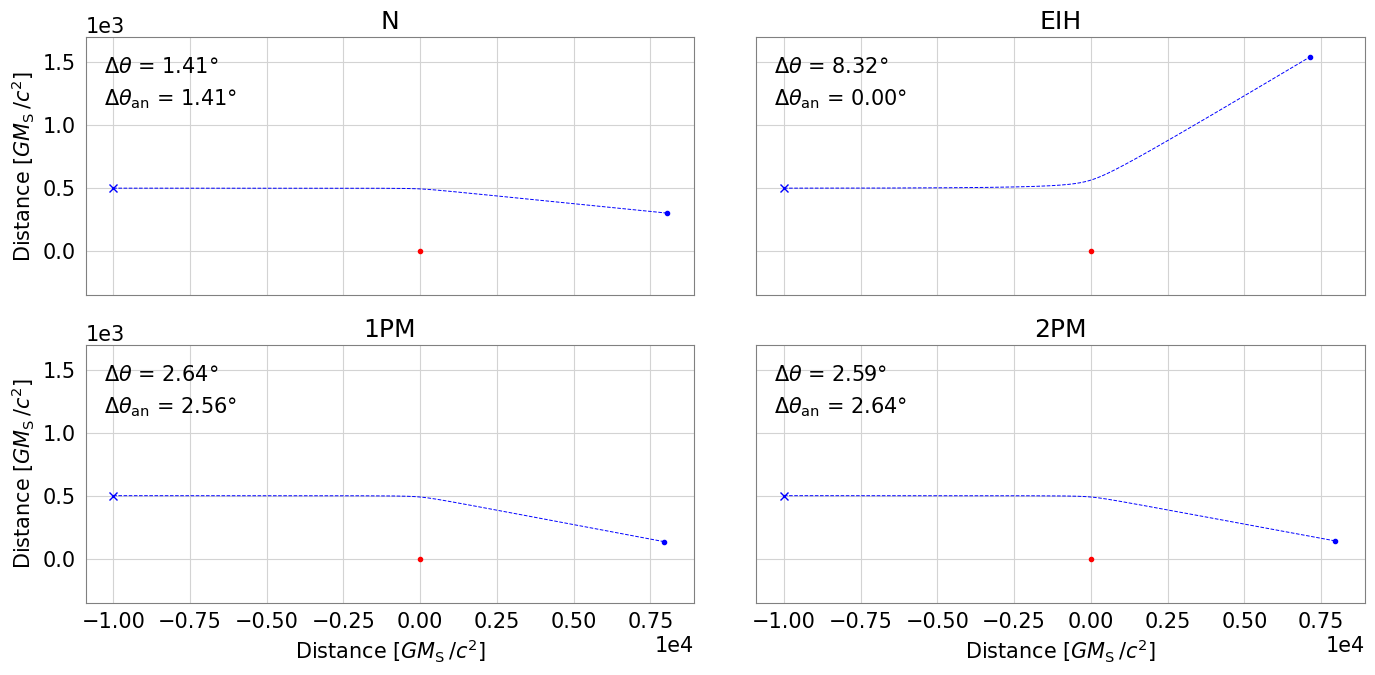

In [203]:
plt.style.use('default')
plt.rcParams.update({'font.size':15})

fig, axs = plt.subplots(2,2, figsize=(14,7), sharex = True, sharey = True)


axs[0,0].plot(positions_N[0,0], positions_N[0,1], 'b--', lw=0.7)
axs[0,0].plot(0,0,'w.', markersize=1, label=f'$Δθ$ = {scatteringAngle(positions_N):.2f}°')
axs[0,0].plot(0,0,'w.', markersize=1, label='$Δθ_\mathrm{an}$ = '+f'{θ_N_an[0]:.2f}°')
axs[0,0].plot(0,0,'r.')
axs[0,0].plot(positions_N[0,0][-1], positions_N[0,1][-1], 'b.')
axs[0,0].plot(positions_N[0,0][0], positions_N[0,1][0], 'bx')
axs[0,0].set_title('N')
axs[0,0].set_ylim(-350, 1700)
axs[0,0].set_ylabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[0,0].ticklabel_format(scilimits=(0,2))
axs[0,0].legend(loc=(-0.08, 0.68), frameon=False)


axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].plot(0,0,'w.', markersize=1, label=f'$Δθ$ = {scatteringAngle(positions_EIH):.2f}°')
axs[0,1].plot(0,0,'w.', markersize=1, label='$Δθ_\mathrm{an}$ = '+f'{θ_EIH_an[0]:.2f}°')
axs[0,1].plot(0,0,'r.')
axs[0,1].plot(positions_EIH[0,0][-1], positions_EIH[0,1][-1], 'b.')
axs[0,1].plot(positions_EIH[0,0][0], positions_EIH[0,1][0], 'bx')
axs[0,1].set_title('EIH')
axs[0,1].legend(loc=(-0.08, 0.68), frameon=False)

axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].plot(0,0,'w.', markersize=1, label=f'$Δθ$ = {scatteringAngle(positions_1PM):.2f}°')
axs[1,0].plot(0,0,'w.', markersize=1, label='$Δθ_\mathrm{an}$ = '+f'{θ_1PM_an[0]:.2f}°')
axs[1,0].plot(0,0,'r.')
axs[1,0].plot(positions_1PM[0,0][-1], positions_1PM[0,1][-1], 'b.')
axs[1,0].plot(positions_1PM[0,0][0], positions_1PM[0,1][0], 'bx')
axs[1,0].set_title('1PM')
axs[1,0].set_ylabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,0].set_xlabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,0].ticklabel_format(scilimits=(0,2))
axs[1,0].legend(loc=(-0.08, 0.68), frameon=False)

axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].plot(0,0,'w.', markersize=1, label=f'$Δθ$ = {scatteringAngle(positions_2PM):.2f}°')
axs[1,1].plot(0,0,'w.', markersize=1, label='$Δθ_\mathrm{an}$ = '+f'{θ_2PM_an[0]:.2f}°')
axs[1,1].plot(0,0,'r.')
axs[1,1].plot(positions_2PM[0,0][-1], positions_2PM[0,1][-1], 'b.')
axs[1,1].plot(positions_2PM[0,0][0], positions_2PM[0,1][0], 'bx')
axs[1,1].set_title('2PM')
axs[1,1].set_xlabel('Distance $[G M_\mathrm{S} \,/ c^2]$')
axs[1,1].ticklabel_format(scilimits=(0,2))
axs[1,1].legend(loc=(-0.08, 0.68), frameon=False)

# for i in range(len(peakPositions_EIH)):
#     axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
#     axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
#     axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
#     axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')

axs = axs.flatten()

for ax in axs:
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.grid(color='lightgray')

fig.tight_layout()

# fig.savefig('test body scattering 2.jpg', dpi=300)


In [103]:
m_1 = 1e-6
m_2 = 1

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 400.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.3,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2


t_max = 5e4
res = 1e4
dt = t_max/res

leng = 11

θs_N = np.zeros(leng)
θs_N_an = np.zeros(leng)
Ls_N = np.zeros(leng)

θs_EIH = np.zeros(leng)
θs_EIH_an = np.zeros(leng)
Ls_EIH = np.zeros(leng)

θs_1PM = np.zeros(leng)
θs_1PM_an = np.zeros(leng)
Ls_1PM = np.zeros(leng)

θs_2PM = np.zeros(leng)
θs_2PM_an = np.zeros(leng)
Ls_2PM = np.zeros(leng)

θ_test = np.zeros(leng)


for i in range(leng):
    v_1 = np.array([0.3,   0.])
    v_1 += np.array([0.03*i, 0])
    print(v_1)
    s = x_1, x_2, v_1, v_2, m_1, m_2

    positions_N = run_model(s, t_max, dt, DL = True, mode = 'N', scattering=False)
    positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH', scattering=False)
    positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM', scattering=False)
    positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM', scattering=False)

    θs_N[i] = scatteringAngle(positions_N)
    θs_N_an[i], Ls_N[i] = scatteringAngle_analytical(s, DL = True, mode ='N')

    θs_EIH[i] = scatteringAngle(positions_EIH)
    Ls_EIH[i] = scatteringAngle_analytical(s, DL = True, mode ='N')[1]

    θs_1PM[i] = scatteringAngle(positions_1PM)
    θs_1PM_an[i], Ls_1PM[i] = scatteringAngle_analytical(s, DL = True, mode ='1PM')

    θs_2PM[i] = scatteringAngle(positions_2PM)
    θs_2PM_an[i], Ls_2PM[i] = scatteringAngle_analytical(s, DL = True, mode ='2PM')

    θ_test[i] = otherScatteringAngleAnalytical(s, DL = True)

# 5m 5s at res = 3e4


[0.3 0. ]
[0.33 0.  ]
[0.36 0.  ]
[0.39 0.  ]
[0.42 0.  ]
[0.45 0.  ]
[0.48 0.  ]
[0.51 0.  ]
[0.54 0.  ]
[0.57 0.  ]
[0.6 0. ]


In [104]:
θ_test, θs_2PM_an

(array([3.50834778, 2.94938152, 2.5242037 , 2.19330062, 1.93073385,
        1.71890695, 1.54554225, 1.40186249, 1.28145826, 1.17956095,
        1.09256336]),
 array([3.50792494, 2.94897747, 2.52385209, 2.19300457, 1.9304872 ,
        1.71870159, 1.54537058, 1.40171809, 1.28133591, 1.17945648,
        1.09247348]))

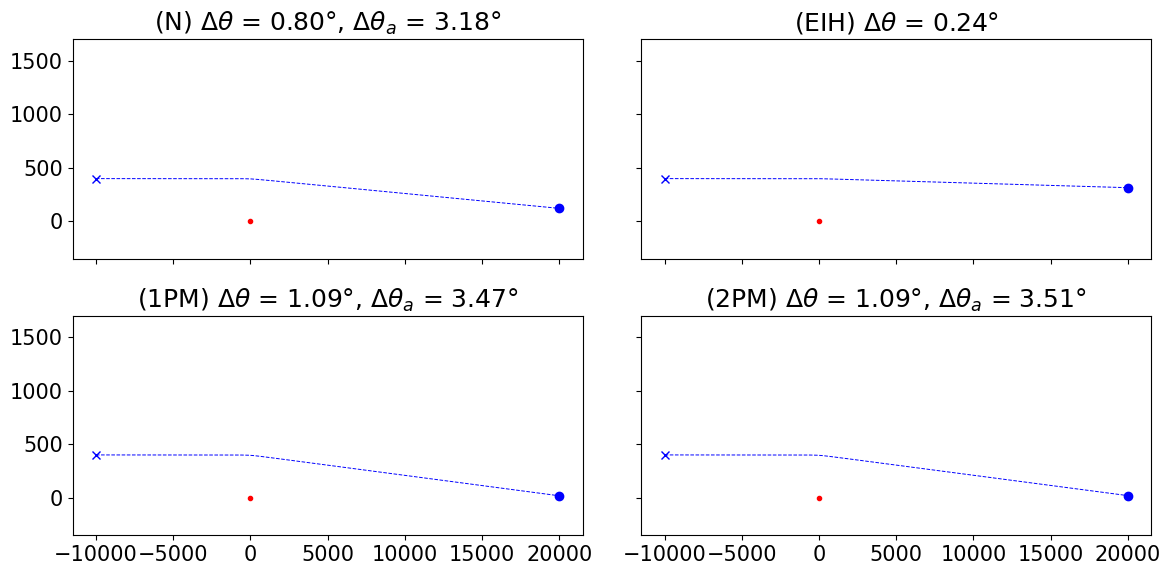

In [106]:
fig, axs = plt.subplots(2,2, figsize=(12,6), sharex = True, sharey = True)


axs[0,0].plot(positions_N[0,0], positions_N[0,1], 'b--', lw=0.7)
axs[0,0].plot(0,0,'r.')
axs[0,0].plot(positions_N[0,0][-1], positions_N[0,1][-1], 'bo')
axs[0,0].plot(positions_N[0,0][0], positions_N[0,1][0], 'bx')
axs[0,0].set_title(f'(N) $Δθ$ = {scatteringAngle(positions_N):.2f}°, $Δθ_a$ = {θs_N_an[0]:.2f}°')
axs[0,0].set_ylim(-350, 1700)

axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].plot(0,0,'r.')
axs[0,1].plot(positions_EIH[0,0][-1], positions_EIH[0,1][-1], 'bo')
axs[0,1].plot(positions_EIH[0,0][0], positions_EIH[0,1][0], 'bx')
axs[0,1].set_title(f'(EIH) $Δθ$ = {scatteringAngle(positions_EIH):.2f}°')

axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].plot(0,0,'r.')
axs[1,0].plot(positions_1PM[0,0][-1], positions_1PM[0,1][-1], 'bo')
axs[1,0].plot(positions_1PM[0,0][0], positions_1PM[0,1][0], 'bx')
axs[1,0].set_title(f'(1PM) $Δθ$ = {scatteringAngle(positions_1PM):.2f}°, $Δθ_a$ = {θs_1PM_an[0]:.2f}°')

axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].plot(0,0,'r.')
axs[1,1].plot(positions_2PM[0,0][-1], positions_2PM[0,1][-1], 'bo')
axs[1,1].plot(positions_2PM[0,0][0], positions_2PM[0,1][0], 'bx')
axs[1,1].set_title(f'(2PM) $Δθ$ = {scatteringAngle(positions_2PM):.2f}°, $Δθ_a$ = {θs_2PM_an[0]:.2f}°')
# for i in range(len(peakPositions_EIH)):
#     axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
#     axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
#     axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
#     axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
fig.tight_layout()


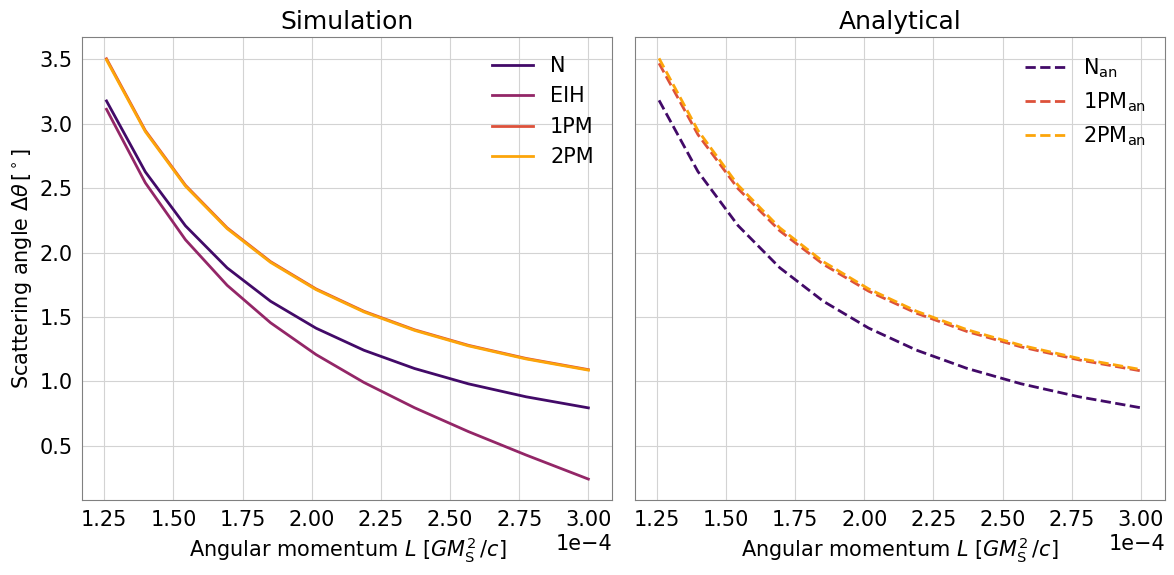

In [128]:
palette = sns.color_palette('inferno', 4).as_hex()

x = np.linspace(Ls_N[0], Ls_N[-1], 11)
ones = np.ones_like(x)

plt.style.use('default')
plt.rcParams.update({'font.size':15})

fig, axs = plt.subplots(1,2, figsize=(12,6), sharex = True, sharey=True)

axs[0].plot(Ls_N, θs_N, color=palette[0], lw=2, label='N')
axs[0].plot(Ls_EIH, θs_EIH, color=palette[1], lw=2, label='EIH')
axs[0].plot(Ls_1PM, θs_1PM, color=palette[2], lw=2, label='1PM')
axs[0].plot(Ls_2PM, θs_2PM, color=palette[3], lw=2, label='2PM')

# axs[0].plot(x,ones, 'k:', lw=0.5, label='θ = 1.0')
# axs[0].set_xlabel('Angular momentum L [kg m^2/s]')

axs[0].set_xlabel('Angular momentum $L\ [G M_\mathrm{S}^2 \,/ c]$')
axs[0].set_ylabel('Scattering angle $Δθ \, \mathrm{[^\circ]}$')
axs[0].ticklabel_format(scilimits=(0,3))
axs[0].legend(frameon=False)
axs[0].set_title('Simulation')


axs[1].plot(Ls_N, θs_N_an, color=palette[0], ls='--', lw=2, label='$\mathrm{N_{an}}$')
axs[1].plot(Ls_1PM, θs_1PM_an, color=palette[2], ls='--', lw=2, label='$\mathrm{1PM_{an}}$')
axs[1].plot(Ls_2PM, θs_2PM_an, color=palette[3], ls='--', lw=2, label='$\mathrm{2PM_{an}}$')

# axs[1].plot(x,ones, 'k:' , lw=0.5, label='θ = 1.0')

axs[1].set_xlabel('Angular momentum $L\ [G M_\mathrm{S}^2 \,/ c]$')
axs[1].ticklabel_format(scilimits=(0,3))
axs[1].legend(frameon=False)
axs[1].set_title('Analytical')


axs = axs.flatten()

for ax in axs:
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.grid(color='lightgray')

fig.tight_layout()
# fig.savefig('Scattering angle of L multiplot.jpg', dpi=300)

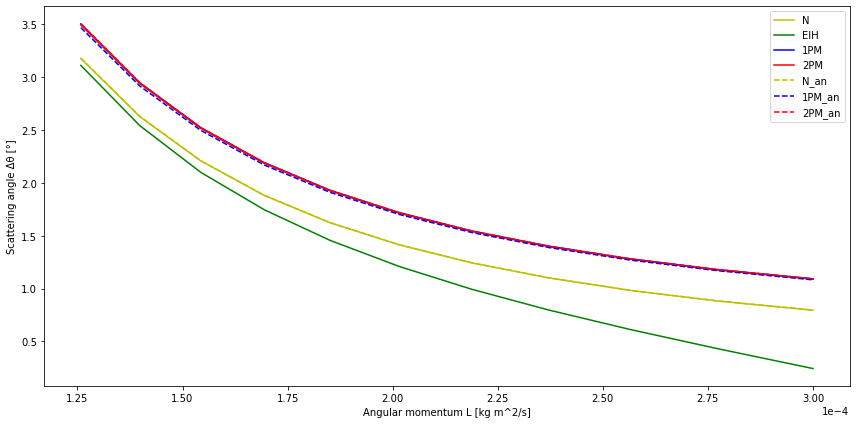

In [29]:
x = np.linspace(Ls_N[0], Ls_N[-1], 11)
ones = np.ones_like(x)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(Ls_N, θs_N, 'y', label='N'), ax.plot(Ls_EIH, θs_EIH,'g', label='EIH'), ax.plot(Ls_1PM, θs_1PM, 'b', label='1PM'), ax.plot(Ls_2PM, θs_2PM, 'r', label='2PM')
ax.plot(Ls_N, θs_N_an,'y--', label='N_an'), ax.plot(Ls_1PM, θs_1PM_an, 'b--', label='1PM_an'), ax.plot(Ls_2PM, θs_2PM_an, 'r--', label='2PM_an')
# ax.plot(x,ones, 'k:', lw=0.5, label='θ = 1.0')
ax.set_xlabel('Angular momentum L [kg m^2/s]')
ax.set_ylabel('Scattering angle Δθ [°]')
ax.ticklabel_format(scilimits=(0,3))
ax.legend()
# ax.set_title('Δθ(L) - Simulated')

fig.tight_layout()
fig.savefig('Scattering angle of L oneplot.jpg', dpi=300)

In [129]:
m_1 = 1e-6
m_2 = 1

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 400.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.6,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2


t_max = 5e4
res = 1e4
dt = t_max/res

leng = 11

θs_N = np.zeros(leng)
θs_N_an = np.zeros(leng)
Ls_N = np.zeros(leng)

θs_1PM = np.zeros(leng)
θs_1PM_an = np.zeros(leng)
Ls_1PM = np.zeros(leng)

θs_2PM = np.zeros(leng)
θs_2PM_an = np.zeros(leng)
Ls_2PM = np.zeros(leng)

θ_test = np.zeros(leng)


for i in range(leng):
    v_1 = np.array([0.6,   0.])
    v_1 += np.array([0.03*i, 0])
    print(v_1)
    s = x_1, x_2, v_1, v_2, m_1, m_2

    positions_N = run_model(s, t_max, dt, DL = True, mode = 'N', scattering=False)
    positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM', scattering=False)
    positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM', scattering=False)

    θs_N[i] = scatteringAngle(positions_N)
    θs_N_an[i], Ls_N[i] = scatteringAngle_analytical(s, DL = True, mode ='N')

    θs_1PM[i] = scatteringAngle(positions_1PM)
    θs_1PM_an[i], Ls_1PM[i] = scatteringAngle_analytical(s, DL = True, mode ='1PM')

    θs_2PM[i] = scatteringAngle(positions_2PM)
    θs_2PM_an[i], Ls_2PM[i] = scatteringAngle_analytical(s, DL = True, mode ='2PM')

    θ_test[i] = otherScatteringAngleAnalytical(s, DL = True)

# 5m 5s at res = 3e4


[0.6 0. ]
[0.63 0.  ]
[0.66 0.  ]
[0.69 0.  ]
[0.72 0.  ]
[0.75 0.  ]
[0.78 0.  ]
[0.81 0.  ]
[0.84 0.  ]
[0.87 0.  ]
[0.9 0. ]


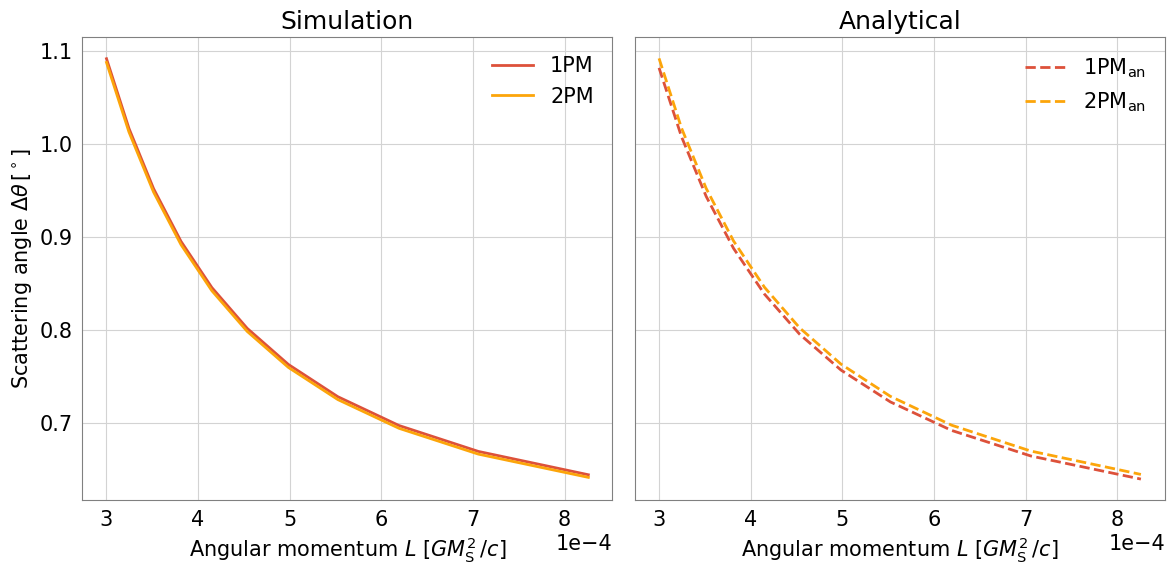

In [131]:
palette = sns.color_palette('inferno', 4).as_hex()

x = np.linspace(Ls_N[0], Ls_N[-1], 11)
ones = np.ones_like(x)

plt.style.use('default')
plt.rcParams.update({'font.size':15})

fig, axs = plt.subplots(1,2, figsize=(12,6), sharex = True, sharey=True)

axs[0].plot(Ls_1PM, θs_1PM, color=palette[2], lw=2, label='1PM')
axs[0].plot(Ls_2PM, θs_2PM, color=palette[3], lw=2, label='2PM')
axs[0].set_xlabel('Angular momentum $L\ [G M_\mathrm{S}^2 \,/ c]$')
axs[0].set_ylabel('Scattering angle $Δθ \, \mathrm{[^\circ]}$')
axs[0].ticklabel_format(scilimits=(0,3))
axs[0].legend(frameon=False)
axs[0].set_title('Simulation')


axs[1].plot(Ls_1PM, θs_1PM_an, color=palette[2], ls='--', lw=2, label='$\mathrm{1PM_{an}}$')
axs[1].plot(Ls_2PM, θs_2PM_an, color=palette[3], ls='--', lw=2, label='$\mathrm{2PM_{an}}$')
axs[1].set_xlabel('Angular momentum $L\ [G M_\mathrm{S}^2 \,/ c]$')
axs[1].ticklabel_format(scilimits=(0,3))
axs[1].legend(frameon=False)
axs[1].set_title('Analytical')


axs = axs.flatten()

for ax in axs:
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.grid(color='lightgray')

fig.tight_layout()
fig.savefig('Scattering angle of L ultra-relativistic.jpg', dpi=300)

TypeError: Image data of dtype object cannot be converted to float

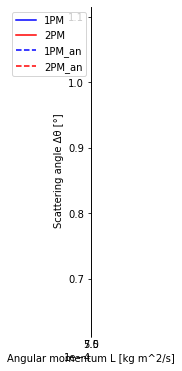

In [32]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

x = np.linspace(Ls_N[0], Ls_N[-1], 11)
ones = np.ones_like(x)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(Ls_1PM, θs_1PM, 'b', label='1PM'), ax.plot(Ls_2PM, θs_2PM, 'r', label='2PM')
ax.plot(Ls_1PM, θs_1PM_an, 'b--', label='1PM_an'), ax.plot(Ls_2PM, θs_2PM_an, 'r--', label='2PM_an')
# ax.plot(x,ones, 'k:', lw=0.5, label='θ = 1.0')
ax.set_xlabel('Angular momentum L [kg m^2/s]')
ax.set_ylabel('Scattering angle Δθ [°]')
ax.ticklabel_format(scilimits=(0,3))
ax.legend()
# ax.set_title('Δθ(L) - Simulated')

extent = ax.get_xlim(), ax.get_ylim()

ax.imshow(ax, extent=extent, origin="lower")

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.imshow(ax, extent=extent, origin="lower")

x1, x2, y1, y2 = 4, 4.01, 0.8, 0.81
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.setp(axins,xticks=[],yticks=[])
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


# fig.tight_layout()
# fig.savefig('Scattering angle of L oneplot ultra.jpg', dpi=300)

In [ ]:
def get_demo_image():
    from matplotlib.cbook import get_sample_data
    import numpy as np
    f = get_sample_data("axes_grid/bivariate_normal.npy", asfileobj=False)
    z = np.load(f)
    # z is a numpy array of 15x15
    return z, (-3, 4, -4, 3)

In [ ]:
Z, extent = get_demo_image()

In [ ]:
Z

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(Z, interpolation="nearest")